In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc


In [3]:
import copy
from collections import defaultdict, namedtuple
from datetime import datetime
import itertools
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import tabulate
import wandb
from tqdm.notebook import tqdm

In [4]:
api = wandb.Api()

In [5]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
Condition = namedtuple('Condition', ('paradigm', 'relation', 'model_config', 'object_size', 'neither'))
ConditionWithModel = namedtuple('ConditionWithModel', ('model_name', 'paradigm', 'relation', 'model_config', 'object_size', 'neither'))
PARADIGM_INDEX = 0
RELATION_INDEX = 1
MODEL_CONFIG_INDEX = 2
OBJECT_SIZE_INDEX = 4
NEITHER_INDEX = 7


def parse_with_without(raw):
    raw = raw.lower().strip()
    assert(raw in ('with', 'without'))
    return raw == 'with'


def name_to_condition(name):
    split = name.split('-')
    paradigm = split[PARADIGM_INDEX]
    relation = split[RELATION_INDEX]
    model_config = split[MODEL_CONFIG_INDEX]
    object_size = parse_with_without(split[OBJECT_SIZE_INDEX])
    neither = parse_with_without(split[NEITHER_INDEX])
    return Condition(paradigm=paradigm, relation=relation, model_config=model_config, 
                     object_size=object_size, neither=neither)


In [8]:
CACHE_PATH = './results_cache.pickle'
BACKUP_CACHE_PATH = './results_cache_{date}.pickle'


def refresh_cache(new_values_dict=None, cache_path=CACHE_PATH):
    if new_values_dict is None:
        new_values_dict = {}
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as cache_file:
            cache = pickle.load(cache_file)
    
    else:
        cache = {}
    
    cache.update(new_values_dict)
    
    if os.path.exists(cache_path):
        os.rename(CACHE_PATH, BACKUP_CACHE_PATH.format(date=datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

    with open(cache_path, 'wb') as cache_file:
        pickle.dump(cache, cache_file)

    return cache
 

cache = refresh_cache()

In [9]:
print(cache.keys())

dict_keys(['all_results', 'all_results_df', 'all_results_fixed_checkpoints', 'all_results_fixed_checkpoints_df', 'all_results_fixed_cnn', 'all_results_fixed_cnn_df', 'quinn_results', 'quinn_results_df', 'quinn_results_learning_curves', 'quinn_parsed_learning_curve_data'])


# Game plan
* Iterate through projects 
* Parse each project conditions from its name
* Aggregate each of the following statistics by model:
    * Peak accuracy
    * Epoch in which peak accuracy takes place
    * Epoch above some accuracy threshold
    * Did the model overfit (delta between train and val?)
* Start examining the effects of different manipulations:
    * Choice of relation
    * Number of objects
    * Size of the training set
    * Size of the model (in that one condition I ran larger)
* Probably more bar charts tables than anything else, unless we need learning curves



In [10]:
def get_model_name(run):
    return run.name.rsplit('-', 1)[0]


def get_run_seed(run):
    return int(run.name.rsplit('-', 1)[1])


def fix_project_configs(project):
    uri = f'{project.entity}/{project.name}'
    print(f'\tIn project {project.name}:')
    runs = api.runs(uri)
    configs_by_model = {}
    runs_to_fix = defaultdict(list)
    
#     for run in tqdm(runs, desc='Runs'):
    for run in runs:
        model_name = get_model_name(run)
        if run.config is None or len(run.config) == 0:
            runs_to_fix[model_name].append(run)

        elif model_name not in configs_by_model:
            configs_by_model[model_name] = copy.deepcopy(run.config)
    
    for model_name in runs_to_fix:
        if model_name not in configs_by_model:
            raise ValueError(f'In URI {uri}, could not find a config to fix model name {model_name}')
            
        sample_config = configs_by_model[model_name]
        
        for run in runs_to_fix[model_name]:
            config_copy = copy.deepcopy(sample_config)
            config_copy['seed'] = get_run_seed(run)
            config_copy['wandb_run_name'] = run.name
            run.config = config_copy
            run.update()
            print(f'\t\t{run.name}')
            
    return runs_to_fix


def print_missing_data(project, num_samples=50000):
    uri = f'{project.entity}/{project.name}'
    print(f'\tIn project {project.name}:')
    runs = api.runs(uri)
    configs_by_model = {}
    runs_to_fix = defaultdict(list)
    
#     for run in tqdm(runs, desc='Runs'):
    for run in runs:
        model_name = get_model_name(run)
        history_df = run.history(samples=num_samples)
        if 'num_objects_gen_test_acc' not in history_df:
            runs_to_fix[model_name].append(run)
            print(f'\t\t{run.name}')
            
    return runs_to_fix


def fix_all_projects(entity='simple-relational-reasoning-fixed-checkpoints', 
                     fix_func=fix_project_configs):
    projects = api.projects(entity)
    results = {}
    
    print(projects)
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
#         print(proj.name)
#         print(condition)
        results[condition] = fix_func(proj)
        
    return results


In [11]:
# fix_results = fix_all_projects(fix_func=print_missing_data)

In [12]:
# fix_results = fix_all_projects()

In [17]:
def parse_single_key(history_df, run_results, key, baseline_key='train_acc', accuracy_threshold=0.95):
    max_index = history_df[key].idxmax()
    run_results[key] = history_df[key][max_index]
    run_results[f'{key}_step'] = history_df.global_step[max_index]
    
    accuracy_above_treshold_index = (history_df[key] >= accuracy_threshold).idxmax()
    threshold_step = None
    if accuracy_above_treshold_index > 0:  # 0 means never went above treshold
        threshold_step = history_df.global_step[accuracy_above_treshold_index]
    run_results[f'{key}_threshold_step'] = threshold_step
    
    if key != baseline_key:
        run_results[f'{key}_diff'] = history_df[baseline_key].max() - run_results[key]
        
        
def parse_single_key_learning_curves(history_df, run_results, key, baseline_key='train_acc', accuracy_threshold=0.95):
    series = history_df[key]
    run_results[key] = np.array(series[series.notnull()])


def parse_run(run, num_samples=50000, baseline_key='train_acc', accuracy_threshold=0.95,
              parse_key_func=parse_single_key):
    history_df = run.history(samples=num_samples)
    run_results = {}
    
    accuracy_keys = [key for key in history_df.keys() if 'acc' in key]
    for key in accuracy_keys:
        parse_key_func(history_df, run_results, key, 
                       baseline_key=baseline_key, accuracy_threshold=accuracy_threshold)
    
    return run_results
    
    
def parse_project(project, parse_key_func=parse_single_key):
    runs = api.runs(f'{project.entity}/{project.name}')
    results_by_model = defaultdict(list)
    
    for run in runs:  # tqdm(runs, desc='Runs'):
        try:
            seed_split_index = run.name.rindex('-')
            model_name = run.name[:seed_split_index]
            seed = int(run.name[seed_split_index + 1:])

            run_results = parse_run(run, parse_key_func=parse_key_func)
            run_results['seed'] = seed
            run_results['total_params'] = run.config['total_params']
            results_by_model[model_name].append(run_results)
            
        except Exception as e:
            print(e)
            print(run)
            print(run.name)
            print(run.config)
            raise(e)
        
    return results_by_model
        
        
def parse_all_projects(entity='quinn-relations', parse_key_func=parse_single_key):
    projects = api.projects(entity)
    results = {}
    
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
#         print(proj.name)
#         print(condition)
        results[condition] = parse_project(proj, parse_key_func=parse_key_func)
        
    return results


if 'quinn_results' not in cache:
    cache['quinn_results'] = parse_all_projects()
    cache = refresh_cache(cache)
    
quinn_results = cache['quinn_results']

if 'quinn_results_learning_curves' not in cache:
    cache['quinn_results_learning_curves'] = parse_all_projects(parse_key_func=parse_single_key_learning_curves)
    cache = refresh_cache(cache)
    
quinn_results_learning_curves = cache['quinn_results_learning_curves']

In [15]:
CONDITION_FIELDS = list(Condition._fields)
COLUMNS = CONDITION_FIELDS + ['model_name'] 


def get_all_columns(results_dict):
    columns = set()
    for condition_to_model_dict in results_dict.values():
        result_list = next(iter(condition_to_model_dict.values()))
        columns.update(result_list[0].keys())
    return columns


def results_dict_to_df(results_dict):
    rows = []
    all_columns = list(get_all_columns(results_dict))
    header_columns = COLUMNS + all_columns
    for condition, results_by_model in tqdm(results_dict.items(), desc='Condition'):
        condition_row_prefix = list(condition)
#         print(condition_row_prefix)
        for model_name, results_by_seed in results_by_model.items():  # tqdm(results_by_model.items(), desc='Result'):
            for run_results in results_by_seed:
                run_result_list = [run_results[field] if field in run_results else None for field in all_columns]
                rows.append(condition_row_prefix + [model_name] + run_result_list)
                
    return pd.DataFrame(rows, columns=header_columns)


if 'quinn_results_df' not in cache:
    cache['quinn_results_df'] = results_dict_to_df(quinn_results)
    cache = refresh_cache(cache)
    
quinn_results_df = cache['quinn_results_df']

In [18]:
def parse_learning_curve_results(results_dict):
    full_results = {}
    for condition, condition_results in tqdm(results_dict.items(), desc='Condition'):
        condition_results = results_dict[condition]
        
        for model_type in condition_results:
            model_type_results = condition_results[model_type]
            condition_and_model_results = defaultdict(list)
            condition_and_model_arrays = {}
            
            for seed_results in model_type_results:
                for result_key, result_value in seed_results.items():
                    if isinstance(result_value, np.ndarray):
                        condition_and_model_results[result_key].append(result_value)
                    
            # TODO: combine to a 2d array
            for result_key, result_values in condition_and_model_results.items():
                max_len = max([len(values) for values in result_values])
                padded_values = [np.pad(values, (0, max_len - len(values)), constant_values=np.nan)
                                 for values in result_values]
                condition_and_model_arrays[result_key] = np.stack(padded_values)
            
            # TODO: create a key from condition and model type
            condition_with_model = ConditionWithModel(model_type, *condition)
            full_results[condition_with_model] = condition_and_model_arrays
            
    return full_results
            
if 'quinn_parsed_learning_curve_data' not in cache:
    cache['quinn_parsed_learning_curve_data'] = parse_learning_curve_results(quinn_results_learning_curves)
    cache = refresh_cache(cache)
    
quinn_parsed_learning_curve_data = cache['quinn_parsed_learning_curve_data']

In [ ]:
quinn_results_df.head()

In [ ]:
quinn_results_df.keys()

In [ ]:
quinn_results_df[[key for key in quinn_results_df.keys() if ('acc' in key or key == 'paradigm') and ('step' not in key)]]

In [ ]:
quinn_results_df.shape

# Plotting thoughts
* I want a single plotting function that will generate a group of bar charts
* Steps:
    1. Filter out particular parts of the dataframe.
    2. Group by one or more fields.
    3. Aggregate (mean, sd) the metric of choice.
    4. Group the bars by one of the group-by fields. 
* I probably want some way to specify formatting by the individual groups left (for example, a color for each model, a striping for each relation, ...)

**TODO:** 
* Pretitfy names
* Model (or other field orders)

In [19]:
DEFAULT_ORDERS = dict(
    model_name=['combined-object-mlp', 'cnn', 'relation-net', 'transformer'],
    relation=['above_below', 'between'],
    one_or_two_references=['train_acc', 'train_reference_test_target_acc', 
                           'test_reference_train_target_acc', 'test_reference_test_target_acc'],
    inductive_bias=['train_acc', 'train_reference_test_target_acc', 'test_reference_train_target_acc', 
                    'test_reference_test_target_acc',  'train_reference_middle_target_acc', 
                    'test_reference_middle_target_acc']
)
DEFAULT_COLORMAP = plt.get_cmap('Dark2')
DEFAULT_BAR_KWARGS_BY_FIELD = defaultdict(lambda: defaultdict(dict))
DEFAULT_BAR_KWARGS_BY_FIELD['model_name'] = {name: dict(facecolor=DEFAULT_COLORMAP(i))
                                             for i, name in enumerate(DEFAULT_ORDERS['model_name'])}
DEFAULT_BAR_KWARGS_BY_FIELD['num_objects'] = {5: {'hatch': ''}, 10: {'hatch': '/'}}

DEFAULT_BAR_KWARGS = dict(edgecolor='black')

SHADE_BAR_KWARGS = dict(alpha=0.25)

DEFAULT_TEXT_KWARGS = dict(fontsize=16)

DEFAULT_YLIM = (0, 1.05)

PRETTY_NAMES = {
    'cnn': 'CNN',
    'combined-object-mlp': 'MLP',
    'relation-net': 'RelationNet',
    'transformer': 'Transformer',
    'train_acc': 'Train Accuracy',
    'train_reference_test_target_acc': 'Train Ref\nTest Target',
    'test_reference_train_target_acc': 'Test Ref\nTrain Target',
    'test_reference_test_target_acc': 'Test Ref\nTest Target',
    'train_reference_middle_target_acc': 'Train Ref\nMid Target',
    'test_reference_middle_target_acc': 'Test Ref\nMid Target',
    'model_config': 'Model Configuration Set',
    'num_objects_gen_test_acc': 'Generalization Test Accuracy',
    '5': '5 Objects',
    '10': '10 Objects',
}


def prettify(text):
    if isinstance(text, int) and text > 1000:
        return f'{text // 1000}k ($2^{{ {int(np.log2(text))} }}$)'
    
    text = str(text)
    
    if text in PRETTY_NAMES:
        return PRETTY_NAMES[text]
    
    for key in PRETTY_NAMES:
        if key in text:
            return PRETTY_NAMES[key]

    return text.lower().replace('_', ' ').title()


def filter_and_group(df, filter_dict, group_by_fields, 
                     orders=DEFAULT_ORDERS):
    filtered_df = df.copy(deep=True)
    group_by_fields = group_by_fields[:]
    if 'metric' in group_by_fields:
        group_by_fields.remove('metric')
    
    if filter_dict is not None:
        for filter_name, filter_value in filter_dict.items():
            if isinstance(filter_value, (list, tuple)):
                filtered_df = filtered_df[filtered_df[filter_name].isin(filter_value)]
                if filter_name in orders:
                    orders[filter_name] = list(filter(lambda v: v in filter_value, orders[filter_name]))
            else:
                filtered_df = filtered_df[filtered_df[filter_name].eq(filter_value)]
            
    return filtered_df.groupby(group_by_fields)


def create_mean_and_std(df, filter_dict, group_by_fields, metric,
                     orders=DEFAULT_ORDERS, sem=False, metric_suffix=None,
                     mean_func=None):
    orders = copy.deepcopy(orders)
    if metric is None:
        if 'paradigm' not in filter_dict:
            raise ValueError('metric=None requires specifying a paradigm in filter_dict')
        
        metric = orders[filter_dict['paradigm']]
        if metric_suffix is not None:
            metric = [m + metric_suffix for m in metric]
            
        orders['metric'] = metric
    
    grouped_df = filter_and_group(df, filter_dict, group_by_fields, orders)
    if mean_func is None:
        mean = grouped_df[metric].mean()
    else:
        mean = mean_func(grouped_df[metric])
        
    std = grouped_df[metric].std()    
    if sem:
        std /= np.sqrt(grouped_df[metric].count())
        
    return mean, std, grouped_df, orders



def create_bar_chart(df, filter_dict, group_by_fields, metric,
                     orders=DEFAULT_ORDERS, sem=False, metric_suffix=None,
                     mean_func=None ,title=None,
                     bar_kwargs_by_field=DEFAULT_BAR_KWARGS_BY_FIELD,
                     bar_width=0.2, bar_spacing=0.5, default_bar_kwargs=DEFAULT_BAR_KWARGS,
                     text_kwargs=DEFAULT_TEXT_KWARGS, shade_metric=None, 
                     shade_bar_kwargs=SHADE_BAR_KWARGS, plot_shade_std=False,
                     add_chance_hline=True, plot_std=True, ylim=DEFAULT_YLIM, ylabel='Accuracy', 
                     legend_loc='best', save_path=None, save_should_print=False, 
                     ax=None, legend=True, should_show=False):
    
    group_by_fields = list(group_by_fields)
    
    mean, std, grouped_df, orders = create_mean_and_std(
        df, filter_dict, group_by_fields, metric,
        orders, sem, metric_suffix, mean_func)
    
    major_group_by = group_by_fields[0]
    minor_group_by = group_by_fields[1:]
    
    if default_bar_kwargs is None:
        default_bar_kwargs = dict()
    
    if shade_bar_kwargs is None:
        shade_bar_kwargs = dict()
    
    shade_bar_kwargs_temp = copy.deepcopy(default_bar_kwargs)
    shade_bar_kwargs_temp.update(shade_bar_kwargs)
    shade_bar_kwargs = shade_bar_kwargs_temp
    
    if shade_metric is not None:
        shade_mean = grouped_df[shade_metric].mean()
        shade_std = grouped_df[shade_metric].std()    
        if sem:
            shade_std /= np.sqrt(grouped_df[shade_metric].count())

    if major_group_by in orders:
        major_group_values = orders[major_group_by]
    else:
        major_group_values = mean.index.unique(level=major_group_by)
        
    minor_group_values_list = []
    
    for minor_field_name in minor_group_by:
        if minor_field_name in orders:
            minor_group_values_list.append(orders[minor_field_name])
        else:
            minor_group_values_list.append(mean.index.unique(level=minor_field_name))
    
    major_kwargs = bar_kwargs_by_field[major_group_by]
    minor_kwargs_list = [bar_kwargs_by_field[minor_field_name] for minor_field_name in minor_group_by]
    
    if ax is None:
        figure = plt.figure(figsize=(8, 6))
        ax = plt.gca()
        should_show = True
        
    x = 0
    
    for major_level_value in major_group_values:
        major_level_kwargs = major_kwargs[major_level_value]
        
        for minor_level_value_combination in itertools.product(*minor_group_values_list):
            combined_minor_kwargs = {}
            for i, value in enumerate(minor_level_value_combination):\
                combined_minor_kwargs.update(minor_kwargs_list[i][value])
                
            major_and_minor_key = (major_level_value, *minor_level_value_combination)
            
            if shade_metric:  # intentionally shade before the real bars
                shade_m = shade_mean.loc[major_and_minor_key]
                if plot_shade_std:
                    shade_s = shade_std.loc[major_and_minor_key]
                else:
                    shade_s = 0
                plt.bar(x, shade_m, yerr=shade_s, width=bar_width, **major_level_kwargs, 
                        **combined_minor_kwargs, **shade_bar_kwargs)
            
            if major_group_by == 'metric':
                major_and_minor_key = major_and_minor_key[::-1]
                
            m = mean.loc[major_and_minor_key]
            if plot_std:
                s = std.loc[major_and_minor_key]
            else:
                s = None
            
            ax.bar(x, m, yerr=s, width=bar_width, **major_level_kwargs, 
                    **combined_minor_kwargs, **default_bar_kwargs)

            x += bar_width
        
        x += bar_spacing
        
    minor_group_length = np.product([len(values) for values in minor_group_values_list])
    x_tick_locations = np.arange(len(major_group_values)) * (bar_spacing + bar_width * minor_group_length) +\
                        bar_width * (minor_group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(major_group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([prettify(val) for val in major_group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    if add_chance_hline:
        xlim = plt.xlim()
        ax.hlines(0.5, *xlim, linestyle='--', alpha=0.5)
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel(prettify(major_group_by), **text_kwargs)
    if major_group_by == 'metric':
        ax.set_ylabel(ylabel, **text_kwargs)
    else:
        ax.set_ylabel(prettify(metric), **text_kwargs)
    ax.set_title(title, fontsize=20)
    
    patches = []
    ncol = 0
    for kwarg_set, field_name in zip([major_kwargs] + minor_kwargs_list, group_by_fields):
        if any([len(val) > 0 for val in kwarg_set.values()]):
            ncol += 1
            for field_value in kwarg_set:
                if field_name in filter_dict and field_value not in filter_dict[field_name]:
                    continue
                
                patch_kwargs = dict(facecolor='none', edgecolor='black')
                patch_kwargs.update(kwarg_set[field_value])
                patches.append(matplotlib.patches.Patch(**patch_kwargs, label=prettify(field_value)))
    
    if len(patches) > 0 and legend: 
        ax.legend(handles=patches, loc=legend_loc, ncol=ncol, fontsize=12)
    
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    if should_show:
        plt.show()
    

DEFUALT_OUTCOME_FIELDS = ('max_val_acc', 'num_objects_gen_test_acc') 


def generalization_test_table(df, filter_dict, group_by_fields, 
                              outcome_fields=DEFUALT_OUTCOME_FIELDS,
                              orders=DEFAULT_ORDERS, baseline=False):
    if 'num_objects' not in group_by_fields:
        group_by_fields = (*group_by_fields, 'num_objects')
        
    grouped = filter_and_group(df, filter_dict, group_by_fields, orders=orders)
    means = grouped[outcome_fields].mean()
    variances = grouped[outcome_fields].var()
    counts = grouped[outcome_fields].count()
    
    results_dict = defaultdict(dict)
    
    for key in means.index:
        key_without_num_objects = key[:-1] 
        num_objects = key[-1]
        
        if baseline:
            baseline_col_name = f'Train \\& Test {num_objects}'
            results_dict[key_without_num_objects][baseline_col_name] = f'${means.loc[key][outcome_fields[0]]:.3f}$'
            
        
        mean_diff = means.loc[key][outcome_fields[0]] - means.loc[key][outcome_fields[1]] 
        diff_sd = np.sqrt((variances.loc[key][outcome_fields[0]] / counts.loc[key][outcome_fields[0]]) +
                          (variances.loc[key][outcome_fields[1]] / counts.loc[key][outcome_fields[1]]))
        
        col_name = f'Train {num_objects} $\\rightarrow$ Test {15 - num_objects}'
        results_dict[key_without_num_objects][col_name] = f'${mean_diff:.3f} \\pm {diff_sd:.3f}$'
        
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')  
    results_df = results_df.rename(index=PRETTY_NAMES)
    return results_df


In [55]:
DEFAULT_KWARGS = dict(linewidth=3)
DEFAULT_KWARG_NAME_MAPPING = dict(facecolor='color')

def filter_and_group_learning_curve_data(learning_curve_data, filter_dict,
                                         group_by_fields, orders=DEFAULT_ORDERS):
    grouped_and_filtered_result = defaultdict(dict)
    
    filtered_keys = list(quinn_parsed_learning_curve_data.keys())
    
    group_by_fields = list(group_by_fields)[:]
    if 'metric' in group_by_fields:
        group_by_fields.remove('metric')
    
    if filter_dict is not None:
        for filter_name, filter_value in filter_dict.items():
            if isinstance(filter_value, (list, tuple)):
                filtered_keys = [key for key in filtered_keys if getattr(key, filter_name) in filter_value]
                if filter_name in orders:
                    orders[filter_name] = list(filter(lambda v: v in filter_value, orders[filter_name]))
            else:
                filtered_keys = [key for key in filtered_keys if getattr(key, filter_name) == filter_value]
    
    group_by_field_values = defaultdict(set)
    for group_by_field in group_by_fields:
        for key in filtered_keys:
            group_by_field_values[group_by_field].add(getattr(key, group_by_field))
            
    group_by_field_values = {key: list(value) for key, value in group_by_field_values.items()}
    
    for group_by_field_value_set in itertools.product(*group_by_field_values.values()):
        relevant_keys = [key for key in filtered_keys if 
                         all([getattr(key, prop) == value for (prop, value) in zip(group_by_fields, group_by_field_value_set)])]
        
        for metric in learning_curve_data[relevant_keys[0]].keys():
            metric_values = [learning_curve_data[key][metric] for key in relevant_keys]
            max_len = max([values.shape[1] for values in metric_values])
            padded_metric_values = [np.pad(values, ((0, 0), (0, max_len - values.shape[1])), constant_values=np.nan)
                                   for values in metric_values]
            
            metric_matrix = np.concatenate(padded_metric_values, axis=0)                             
            grouped_and_filtered_result[group_by_field_value_set][metric] = metric_matrix
        
    return grouped_and_filtered_result


def create_learning_curves(data, filter_dict, group_by_fields, metrics,
                           orders=DEFAULT_ORDERS, sem=False, last_value_pad=False,
                           title=None, kwargs_by_field=DEFAULT_BAR_KWARGS_BY_FIELD,
                           default_kwargs=DEFAULT_KWARGS, text_kwargs=DEFAULT_TEXT_KWARGS,
                           kwarg_name_mapping=DEFAULT_KWARG_NAME_MAPPING,
                           add_chance_hline=True, plot_std=True, ylim=DEFAULT_YLIM, 
                           ylabel='Accuracy', xlabel='Step',
                           legend_loc='best', save_path=None, save_should_print=False, 
                           ax=None, legend=True, should_show=False):
    
    group_by_fields = list(group_by_fields)[:]
    if 'metric' in group_by_fields:
        group_by_fields.remove('metric')
    
    filtered_and_grouped_data = filter_and_group_learning_curve_data(data, filter_dict, group_by_fields, orders)
    
    if default_kwargs is None:
        default_kwargs = dict()
        
    if ax is None:
        figure = plt.figure(figsize=(8, 6))
        ax = plt.gca()
        should_show = True
    
    keys_to_kwargs = {}
    
    for final_key in filtered_and_grouped_data:
        for metric in metrics:
            kwargs = default_kwargs.copy()
            for field_name, value in zip(group_by_fields, final_key):
                if field_name in kwargs_by_field:
                    kwargs.update(kwargs_by_field[field_name][value])
                    
            for kwarg_key in kwarg_name_mapping:
                if kwarg_key in kwargs:
                    kwargs[kwarg_name_mapping[kwarg_key]] = kwargs.pop(kwarg_key)
                    
            keys_to_kwargs[final_key] = kwargs
            
            metric_values = filtered_and_grouped_data[final_key][metric]
            
            if last_value_pad:
                metric_values = np.copy(metric_values)
                max_non_nan = metric_values.shape[1] - (~np.isnan(metric_values))[:, ::-1].argmax(1) - 1
                print(max_non_nan.mean(), max_non_nan.std())
                for r, c in zip(np.arange(max_non_nan.shape[0]), max_non_nan):
                    metric_values[r, c:] = metric_values[r, c]
            
            m = np.nanmean(metric_values, 0)
            x = np.arange(len(m))
            ax.plot(x, m, **kwargs)
            
            if plot_std:
                s = np.nanstd(metric_values, 0)
                if sem:
                    s /= np.sqrt(metric_values.shape[0])
                    
                ax.fill_between(x, m - s, m + s, alpha=0.5, **kwargs)
            
    if add_chance_hline:
        xlim = plt.xlim()
        ax.hlines(0.5, *xlim, linestyle='--', alpha=0.5)
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        ax.set_ylim(*ylim)

    ax.set_xlabel(xlabel, **text_kwargs)
    ax.set_ylabel(ylabel, **text_kwargs)
    ax.set_title(title, fontsize=20)
    
    patches = []
    ncol = 1
    for (key, kwargs) in  keys_to_kwargs.items():
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label='-'.join([prettify(k) for k in key])))
    
    if len(patches) > 0 and legend: 
        ax.legend(handles=patches, loc=legend_loc, ncol=ncol, fontsize=12)
    
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    if should_show:
        plt.show()
        

<ipython-input-55-c42944f3672b>:122: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.append(matplotlib.patches.Patch(**patch_kwargs, label='-'.join([prettify(k) for k in key])))
<ipython-input-55-c42944f3672b>:122: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.append(matplotlib.patches.Patch(**patch_kwargs, label='-'.join([prettify(k) for k in key])))


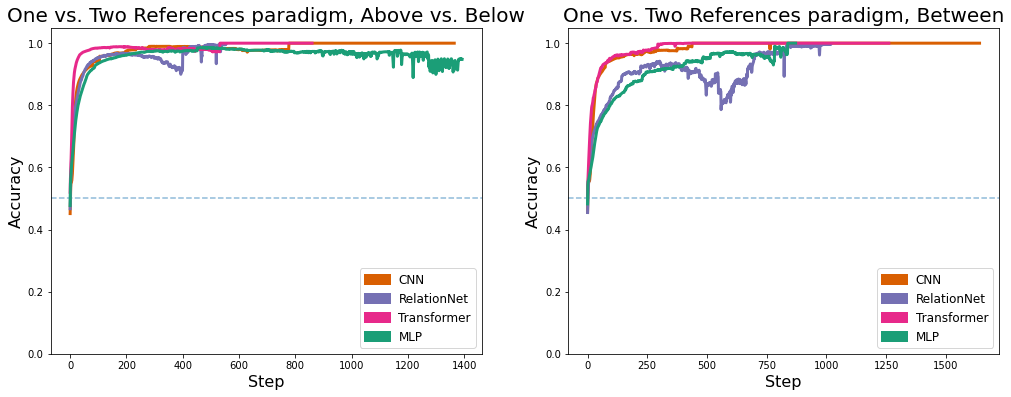

In [57]:
fig = plt.figure(figsize=(17, 6))

above_below_ax = plt.subplot(1, 2, 1)
create_learning_curves(quinn_parsed_learning_curve_data, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'), plot_std=False, # last_value_pad=True,
                 metrics=('train_acc',), legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two References paradigm, Above vs. Below', ax=above_below_ax
                )

between_ax = plt.subplot(1, 2, 2)
create_learning_curves(quinn_parsed_learning_curve_data, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'), plot_std=False,
                 metrics=('train_acc',), legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two References paradigm, Between', ax=between_ax
                )



In [43]:
filtered_and_grouped_data = filter_and_group_learning_curve_data(quinn_parsed_learning_curve_data, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'))

In [47]:
a = next(iter(filtered_and_grouped_data.values()))['train_acc']

array([ 196,  156,  233,  776,  255,  156,  279,  204,  104,  145,  251,
        355,   77,  610,  105,   83,  256,  133,  956,   88,  295,  111,
         91,  424,  235,  179,  355,   80,  138,  235, 1054,  455, 1364,
        520,  168,  889,  522,  306,  477,  588])

In [50]:
a[0, 197]

nan

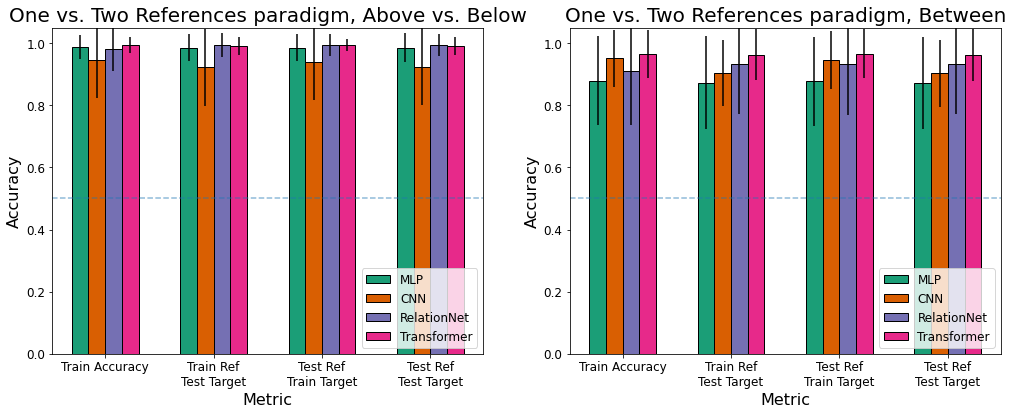

In [33]:
fig = plt.figure(figsize=(17, 6))

above_below_ax = plt.subplot(1, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two References paradigm, Above vs. Below', ax=above_below_ax
                )

between_ax = plt.subplot(1, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two References paradigm, Between', ax=between_ax
                )



In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_prop_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='lower right', ylim=None, add_chance_hline=False,
                 mean_func=lambda x: x.count() / 40, ylabel='Proportion of runs reaching 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | % to 95% acc ', ax=above_below_prop_ax
                )

above_below_step_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='upper right', ylim=None, add_chance_hline=False,
#                  mean_func=lambda x: x.count() / 40, 
                 ylabel='Mean global step to 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | Step to 95% acc ', ax=above_below_step_ax
                )

between_prop_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='lower right', ylim=None, add_chance_hline=False,
                 mean_func=lambda x: x.count() / 40, ylabel='Proportion of runs reaching 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | % to 95% acc', ax=between_prop_ax
                )

between_step_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='upper right', ylim=None, add_chance_hline=False,
#                  mean_func=lambda x: x.count() / 40, 
                 ylabel='Mean global step to 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | Step to 95% acc ', ax=between_step_ax
                )

What happens when we add neither?

In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_no_neither_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  neither=False, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | No neither', ax=above_below_no_neither_ax
                )


above_below_neither_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  neither=True, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | With neither', ax=above_below_neither_ax
                )


between_no_neither_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  neither=False, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | No neither', ax=between_no_neither_ax
                )

between_neither_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  neither=True, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | With neither', ax=between_neither_ax
                )


In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_no_neither_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  object_size=False, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | No object size', ax=above_below_no_neither_ax
                )

above_below_neither_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  object_size=True, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Above vs. Below | With object size', ax=above_below_neither_ax
                )

between_no_neither_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  object_size=False, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | No object size', ax=between_no_neither_ax
                )

between_neither_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='one_or_two_references', model_config='default', 
                                  object_size=True, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='One vs. Two | Between | With object size', ax=between_neither_ax
                )


In [ ]:
fig = plt.figure(figsize=(17, 6))

above_below_ax = plt.subplot(1, 2, 1)

create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias paradigm, Above vs. Below', ax=above_below_ax
                )

between_ax = plt.subplot(1, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias paradigm, Between', ax=between_ax
                )



In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_prop_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='upper right', ylim=None, add_chance_hline=False,
                 mean_func=lambda x: x.count() / 40, ylabel='Proportion of runs reaching 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | % to 95% acc ', ax=above_below_prop_ax
                )

above_below_step_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='upper center', ylim=None, add_chance_hline=False,
#                  mean_func=lambda x: x.count() / 40, 
                 ylabel='Mean global step to 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | Step to 95% acc ', ax=above_below_step_ax
                )

between_prop_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='upper right', ylim=None, add_chance_hline=False,
                 mean_func=lambda x: x.count() / 40, ylabel='Proportion of runs reaching 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | % to 95% acc', ax=between_prop_ax
                )

between_step_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, plot_std=False, metric_suffix='_threshold_step', 
                 legend_loc='lower right', ylim=None, add_chance_hline=False,
#                  mean_func=lambda x: x.count() / 40, 
                 ylabel='Mean global step to 95% accuracy',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | Step to 95% acc ', ax=between_step_ax
                )

In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_no_neither_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=False, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | No object size', ax=above_below_no_neither_ax
                )

above_below_neither_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=True, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | With object size', ax=above_below_neither_ax
                )

between_no_neither_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=False, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | No object size', ax=between_no_neither_ax
                )

between_neither_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=True, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | With object size', ax=between_neither_ax
                )


In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_no_neither_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  neither=False, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | No neither', ax=above_below_no_neither_ax
                )

above_below_neither_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  neither=True, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | With neither', ax=above_below_neither_ax
                )

between_no_neither_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  neither=False, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | No neither', ax=between_no_neither_ax
                )

between_neither_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  neither=True, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | With neither', ax=between_neither_ax
                )


In [ ]:
fig = plt.figure(figsize=(17, 16))

above_below_no_neither_ax = plt.subplot(2, 2, 1)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=False, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | No object size', ax=above_below_no_neither_ax
                )

above_below_neither_ax = plt.subplot(2, 2, 2)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=True, relation='above_below'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Above vs. Below | With object size', ax=above_below_neither_ax
                )

between_no_neither_ax = plt.subplot(2, 2, 3)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=False, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | No object size', ax=between_no_neither_ax
                )

between_neither_ax = plt.subplot(2, 2, 4)
create_bar_chart(quinn_results_df, 
                 filter_dict=dict(paradigm='inductive_bias', model_config='default', 
                                  object_size=True, relation='between'), 
                 group_by_fields=('metric', 'model_name'),
                 metric=None, legend_loc='lower right',
#                  save_path='default_5_16k_group_by_relation.pdf',
                 title='Inductive Bias | Between | With object size', ax=between_neither_ax
                )


## Open questions
* What's the effect of adding neither
* What's the effect of using object sizes
* Is there a big difference in the # of epochs/steps it takes?

**Make slides and send to Brenden afterwards**

In [ ]:
small_gen_table = generalization_test_table(all_results_fixed_cnn_df, 
                                            filter_dict=dict(model_config='default', dataset_size=65536,
                                                             model_name=['combined-object-mlp', 'fixed-cnn',
                                                                         'relation-net', 'transformer']
                                                            ), 
                                            group_by_fields=('relation', 'model_name', 'num_objects'))

small_gen_table.head(10)

In [ ]:
print(small_gen_table.to_latex(escape=False))

In [ ]:
large_gen_table = generalization_test_table(
    all_results_fixed_cnn_df, 
    filter_dict=dict(model_name=['combined-object-mlp', 'fixed-cnn',
                                 'relation-net', 'transformer']
                    ), 
    group_by_fields=('model_config', 'dataset_size', 'relation', 'model_name', 'num_objects'),
    baseline=True)

large_gen_table.head(10)

In [ ]:
large_gen_table.to_latex('./figures/full_generalization_table.txt', escape=False)

# Make a big 'ol table

In [ ]:
table_group_by_columns = ['model_config', 'num_objects', 'dataset_size', 'relation', 'model_name']
custom_sorted_res = all_results_df.copy()
custom_sorted_res['model_name'] = pd.Categorical(custom_sorted_res['model_name'], 
                                                 ['combined-object-mlp', 'cnn', 'relation-net', 'transformer'])
custom_sorted_res['relation'] = pd.Categorical(custom_sorted_res['relation'], 
                                                 ['adjacent', 'above', 'count'])

custom_sorted_res = custom_sorted_res.sort_values('model_name').sort_values('relation')

grouped = custom_sorted_res.groupby(table_group_by_columns, as_index=False)
mean = grouped.mean()
mean.to_latex('./figures/result_table.txt', 
              columns=table_group_by_columns + ['max_val_acc', 'acc_diff'],
              float_format='%.3f', index=False, bold_rows=True)

In [ ]:
all_results_df.head()

In [ ]:
all_results_df[all_results_df.model_name != 'cnn'].acc_diff.max()

In [ ]:
all_results_df.acc_diff.max()

In [ ]:
all_results_df[all_results_df.model_name == 'cnn'].acc_diff.max()

In [ ]:
r = all_results_df[all_results_df.model_config == 'larger']
r.head()
# r = r[r.model_name.is != 'cnn']
# r = r[r.model_name != 'combined-object-mlp']
# r.loc[r.max_val_acc.idxmin()]

In [ ]:
r.num_objects.unique()

In [ ]:
r.dataset_size.unique()

In [ ]:
r.relation.unique()

In [ ]:
all_results_df.groupby(['model_config', 'model_name']).total_params.mean()

In [ ]:
all_results_fixed_checkpoints_df[all_results_fixed_checkpoints_df.model_config != 'default']

In [ ]:
4 * 2 * 3 * 4 * 10

In [ ]:
4 * 2 * 4 * 10

In [ ]:
partial_df.groupby('model_name').mean()

In [ ]:
for relation in ('adjacent', 'above', 'count'):
    d = partial_df[partial_df['relation'] == relation]
    print(d.head())
    print(d.groupby('model_name').max_val_acc.mean())

In [ ]:
partial_df.groupby(['relation', 'model_name']).mean()

In [ ]:
'hello world'.title()

In [ ]:
partial_df.head()

In [ ]:
partial_df.tail()

In [ ]:
d = all_results_df.copy()

In [ ]:
e = d[d['relation'].eq('adjacent')]

In [ ]:
d.shape, e.shape

In [ ]:
g = e.groupby(['num_objects', 'model_name'])

In [ ]:
np.sqrt(g['relation'].count())

In [ ]:
r = g.max_val_acc.mean()

In [ ]:
r.index.unique()

In [ ]:
r.loc[(5, 'cnn')]

In [ ]:
r.index.get_level_values('num_objects')

In [ ]:
history_df = r.history(samples=10000)

In [ ]:
history_df.columns

In [ ]:
history_df.val_acc.idxmax()

In [ ]:
history_df.iloc[3545]

In [ ]:
history_df.iloc[:25]

In [ ]:
2 => 1
5 => 2
8 => 3

In [ ]:
h2 = runs[28].history()
h2[:20]

In [ ]:
h2.val_acc.isnull().sum()

In [ ]:
history_df.val_acc[:501].isnull().sum()

In [ ]:
(h2.val_acc > 0.8).idxmax()

In [ ]:
h2.train_acc.max() - h2.val_acc.max()

In [ ]:
run = api.run('simple-relational-reasoning-fixed-checkpoints/count-relation-default-models-5-objects-4096-dataset/o6p5tg8f')

In [ ]:
parse_run(run)

In [ ]:
files = run.files()

In [ ]:
[f for f in files]

In [ ]:
f = files[0]

In [ ]:
f = list(filter(lambda f: f.name.endswith('.ckpt'), files))[0]

In [ ]:
f.download?

In [ ]:
f.name

In [ ]:
h = run.history()

In [ ]:
'val_acc' in h

In [ ]:
files = valid_run.files()

In [ ]:
f = list(files)[2]

In [ ]:
int([x for x in f.name.split('-') if x.startswith('epoch')][0].split('=')[1])

In [ ]:
import numpy as np

In [ ]:
np.argmax([1, 2, 0])